In [1]:
!pip install tensorflow==2.2.0
!pip install gpflow
!pip install gast
!pip install observations
!git clone https://github.com/jameshensman/VFF.git

     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 491kB 2.7MB/s 
  Created wheel for observations: filename=observations-0.1.4-cp36-none-any.whl size=1319270 sha256=a7f607b9150cb3b0155bffa93298813327bbf2a3a023c9e7178d4eff22f2c567
  Stored in directory: /root/.cache/pip/wheels/21/53/d7/c4d7a5cab86d07b083ebb2e417dcd0cb2bf5dd8c440af675d7
Successfully built observations
Cloning into 'VFF'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 492 (delta 0), reused 1 (delta 0), pack-reused 489
Receiving objects: 100% (492/492), 25.21 MiB | 8.72 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [1]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
import sys
from shutil import copyfile, rmtree
import pickle

import observations

import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0,'./VFF/')

import VFF_IV

helloworld


Make `tensorboard` work inside notebook:

In [0]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [0]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading the snelson dataset

In [0]:
'''
  This code was copied from https://github.com/edwardlib/observations/blob/master/observations/snelson1d.py
  on 01/05/2020
'''

from observations.util import maybe_download_and_extract


def snelson1d(path):
  """Load Edward Snelson's 1d regression data set [@snelson2006fitc].
  It contains 200 examples of a few oscillations of an example function. It has
  seen extensive use as a toy dataset for illustrating qualitative behaviour of
  Gaussian process approximations.
  Args:
    path: str.
      Path to directory which either stores file or otherwise file will be
      downloaded and extracted there. Filenames are `snelson_train_*`.
  Returns:
    Tuple of two np.darray `inputs` and `outputs` with 200 rows and 1 column.
  """
  path = os.path.expanduser(path)
  inputs_path = os.path.join(path, 'snelson_train_inputs')
  outputs_path = os.path.join(path, 'snelson_train_outputs')

  # Contains all source as well. We just need the data.
  url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

  if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
    maybe_download_and_extract(path, url)

    # Copy the required data
    copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
    copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

    # Clean up everything else
    rmtree(os.path.join(path, "SPGP_dist"))
    os.remove(os.path.join(path, "SPGP_dist.zip"))

  X = np.loadtxt(os.path.join(inputs_path))[:, None]
  Y = np.loadtxt(os.path.join(outputs_path))[:, None]

  return X, Y

In [0]:
X, Y = snelson1d(".")
num_train_data = X.shape[0]

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=100
num_batches_per_epoch=6


## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

### 1D Random Variational Fourier Feature Class

In [0]:
class RVFF_1D(gpflow.inducing_variables.InducingVariables):
    def __init__(self, a, b, M):
        self.length = M
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())

        self.phis = gpflow.Parameter(np.random.uniform(0, 2 * np.pi, size=M))
        var = 200
        mean = 30
        self.omegas = gpflow.Parameter( np.random.uniform(0, 150, size=M) ) # np.random.multivariate_normal(mean=mean * np.ones(M), cov = var * np.identity(M)) #np.arange(1, 201, 1, dtype=default_float())  # 

    def __len__(self):
        """ number of inducing variables (defines dimensionality of q(u)) """ 
        return self.length  # M sine components

In [0]:
@cov.Kuu.register(RVFF_1D, gpflow.kernels.Matern12)
def Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=None):
    a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis))(inducing_variable)
    
    lambda_ = 1.0 / kernel.lengthscales

    def innerProduct( intervalLen, omegas, phis, kernelVar, lambda_):
      angle1 = intervalLen * ( omegas[:, None] - omegas[None, :] ) + omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle2 = intervalLen * ( omegas[:, None] + omegas[None, :] ) + omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle3 = omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle4 = omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle5 = 2 * omegas * ( intervalLen + phis )
      angle6 = 2 * omegas * phis

      coeff1 = ( omegas[:, None] * omegas[None, :] + lambda_ * lambda_ ) / (omegas[:, None] - omegas[None, :] + tf.eye(len(inducing_variable), dtype=default_float()))
      coeff2 = ( omegas[:, None] * omegas[None, :] - lambda_ * lambda_ ) / ( omegas[:, None] + omegas[None, :] )
      coeff3 = ( omegas * omegas - lambda_ * lambda_ ) / ( 2 * omegas )

      denom = 4 * kernelVar * kernelVar * lambda_

      firstTerm = ( coeff1 * tf.sin( angle1 ) +
                    coeff2 * tf.sin( angle2 ) -
                    lambda_ * tf.cos( angle2 ) +
                    lambda_ * tf.cos( angle1 ) -
                    coeff1 * tf.sin( angle3 ) -
                    coeff2 * tf.sin( angle4 ) +
                    lambda_ * tf.cos( angle4 ) -
                    lambda_ * tf.cos( angle3 ) ) / denom

      mainDiag = ( ( omegas * omegas + lambda_ * lambda_ ) * intervalLen + 
                   coeff3 * tf.sin( angle5 ) -
                   ( lambda_ * tf.cos( angle5 ) ) - 
                   ( coeff3 * tf.sin( angle6 ) ) +
                   lambda_ * tf.cos( angle6 ) ) / denom

      firstTerm = tf.linalg.set_diag( firstTerm, mainDiag )
      secondTerm = tf.sin( omegas[:, None] * phis[:, None] ) * tf.sin( omegas[None, :] * phis[None, :] ) / ( kernelVar * kernelVar )
      
      res = firstTerm + secondTerm
      res = 0.5 * (res + tf.transpose(res))

      if jitter != None:
        res = res + tf.cast(tf.linalg.diag( jitter * tf.ones( res.shape[0] ) ), default_float())

      return res

    return innerProduct( b - a, omegas, phis, kernel.variance, lambda_ )

@cov.Kuf.register(RVFF_1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_RVFF_1D(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, omegas, phis = (lambda u: (u.a, u.omegas, u.phis))(inducing_variable)       
    return tf.sin( omegas[:, None] * ( X[None, :] - a + phis[:, None]) )

#Model Definition:

###We use exact inference first

In [9]:
tf.config.experimental_run_functions_eagerly(True)

kernel = gpflow.kernels.Matern12(variance=0.5, lengthscales=0.5)
likelihood = gpflow.likelihoods.Gaussian()

exactModel = gpflow.models.GPR( (X, Y), kernel )

gpflow.utilities.set_trainable(kernel.lengthscales, True)
gpflow.utilities.set_trainable(kernel.variance, True)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def loss_closure():
  return -exactModel.log_marginal_likelihood()

Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)

for i in range(500):
  if i % 100 == 0:
    print(i)
    print("kernel lengthscale: %2.2f" % kernel.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel.variance.read_value())
    print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

    mean, std = exactModel.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'm', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=exactModel.trainable_variables )

print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

0
kernel lengthscale: 0.50
kernel variance: 0.50
Exact model log p(y): -216.95


NameError: ignored

###We now use approximate inference with Random Variational Fourier Features

0
kernel lengthscale: 0.70
kernel variance: 1.00
ELBO: -219.59


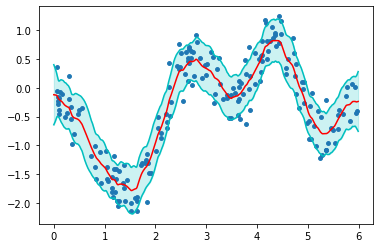

KeyboardInterrupt: ignored

In [13]:
#optimise exact gp wrt hyperparameters (Done)
# use sgpr instead (Done)
#use monte carlo estimate for Kuu ( Done )
#make omegas and phis variational parameters

M = 300
inducing_variable = RVFF_1D( a=0, b=6, M=M )

kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

model = gpflow.models.SGPR(
    (X, Y), kernel=kernel2, inducing_variable=inducing_variable
)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

gpflow.set_trainable(kernel2.variance, False)
gpflow.set_trainable(kernel2.lengthscales, True)
gpflow.set_trainable(likelihood, False)
gpflow.set_trainable(model.inducing_variable.a, False)
gpflow.set_trainable(model.inducing_variable.b, False)
gpflow.set_trainable(model.inducing_variable.phis, True)
gpflow.set_trainable(model.inducing_variable.omegas, True)

@tf.function
def loss_closure():
  return -model.elbo()

for i in range(500):
  if i % 100 == 0:
    print(i)
    print("kernel lengthscale: %2.2f" % kernel2.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel2.variance.read_value())
    print("ELBO: %2.2f" % model.elbo() )

    mean, std = model.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'r', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=model.trainable_variables )

print( "Variational Model ELBO is %3.2f" % model.elbo() )

#Testing

###Plotting a posterior sample on top of the scatter plot of the data:

In [10]:
with open('./model', 'wb') as fp:
    pickle.dump(model.trainable_parameters, fp)
    pickle.dump(inducing_variable.omegas, fp)
    pickle.dump(inducing_variable.phis, fp)

NameError: ignored

In [11]:
with open('./model', 'rb') as fp:
    param_dict = pickle.load(fp)
    omegas = pickle.load(fp)
    phis = pickle.load(fp)

M = 300

inducing_variable = RVFF_1D( a=0, b=6, M=M )
inducing_variable.omegas = omegas
inducing_variable.phis = phis

model = gpflow.models.SGPR((X, Y), kernel=kernel, inducing_variable=inducing_variable)

gpflow.utilities.set_trainable(kernel.lengthscales, False)
gpflow.utilities.set_trainable(kernel.variance, False)
gpflow.utilities.set_trainable(inducing_variable.a, False)
gpflow.utilities.set_trainable(inducing_variable.b, False)

if len(model.trainable_parameters) == len(param_dict):
  for i in range(len(model.trainable_parameters)):
    model.trainable_parameters[i].assign(param_dict[i])

EOFError: ignored

In [12]:
from gpflow.conditionals import conditional

def plot(Xtest, models):

  for (mean, std, meanColour, stdColour) in models:
    plt.plot(Xtest, mean, color=meanColour)

    plt.plot(Xtest, mean + std, color=stdColour)
    plt.plot(Xtest, mean - std, color=stdColour)
    plt.fill_between(np.squeeze(Xtest), np.squeeze(mean + std), np.squeeze(mean - std), color=stdColour, alpha=0.2)
  

  plt.scatter(X, Y, s=15)

  plt.show()

mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

print("ELBO of SGPR model is %4.2f" % model.elbo().numpy())
print("log( p( Y | θ ) ) of exact GP is %4.2f" % exactModel.log_marginal_likelihood().numpy())

NameError: ignored

Testing whether the model is the equivalent to Variational Fourier Features when the frequencies and phases are set manually to correspond to multiples of the base frequency, and not optimised as variational parameters. 

In [22]:
def testFeatureequivalence():
  VFFinducingVar = VFF_IV.FourierFeatures1D(-1, 7, 10)
  VFFmodel = gpflow.models.SGPR((X, Y), kernel2, VFFinducingVar)

  RVFFinducingVar = RVFF_1D(-1, 7, 10)
  RVFFinducingVar.omegas = VFFinducingVar.omegas
  RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)

  kuu = gpflow.covariances.Kuu(RVFFmodel.inducing_variable, kernel2, jitter=default_jitter())
  print(tf.linalg.eigh(kuu)[0])


  print(VFFmodel.elbo())
  print(RVFFmodel.elbo())

testFeatureequivalence()

# mean, std = VFFmodel.predict_f(Xtest, False, False)
# std = tf.sqrt(std)
# plot(Xtest, [(mean, std, 'r', 'c')])

tf.Tensor(
[        nan  3.92785013  7.74344369 13.34392294 21.57583393 32.33075053
 44.71518297 59.45886831 77.46873704 96.97029484], shape=(10,), dtype=float64)
tf.Tensor(-220.4189353124411, shape=(), dtype=float64)


InvalidArgumentError: ignored

Testing whether $q(u) = p(u)$ when we fix q_sqrt = cholesky($K_{uu}$)

In [0]:
kernel = gpflow.kernels.Matern12(variance=5, lengthscales=10.0)
likelihood = gpflow.likelihoods.Gaussian()

M = 200

inducing_variable = RVFF_1D( a=0, b=6, M=M )

def testPriorEqualsPosterior():
  M = 200
  model = gpflow.models.SVGP(
      kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
  )
  q_sqrt = tf.linalg.cholesky( Kuu_matern12_RVFF_1D(model.inducing_variable, model.kernel) )

  return model.prior_kl()

print( "KL[ q(u) | p(u) ] = %2.3f" % testPriorEqualsPosterior() )

Testing whether $K_{uu}$ is computed correctly with Monte-Carlo integration:

In [0]:
def grid_search_integrate(f, bound1, bound2, numOfSamples):
  samples = tf.range(bound1, bound2, ( bound2 - bound1 ) / float(numOfSamples))
  V = tf.math.reduce_prod( bound2 - bound1 )

  return V * tf.math.reduce_sum( f( samples ) ) / numOfSamples

def mattern_half_inner_product_integrand(f, g, df, dg, lambda_):
  def evaluate_on(x):
    return ( lambda_ * f(x) + df(x) ) * ( lambda_ * g(x) + dg(x) )
  return evaluate_on

def grid_search_mattern_half_inner_prod( sigma, lambda_, a, b, omega1, phi1, omega2, phi2 ):
  f = sin(omega1, a, phi1)
  g = sin(omega2, a, phi2)
  
  df = dsin(omega1, a, phi1)
  dg = dsin(omega2, a, phi2)

  integral = grid_search_integrate(
      mattern_half_inner_product_integrand(f, g, df, dg, lambda_),
      a,
      b,
      10e7
  )

  term1 = integral / ( 2 * lambda_ * sigma * sigma )
  term2 = f(a) * g(a) / (sigma * sigma)

  return term1 + term2

def sin( omega, a, phi ):
  def compute_sin(x):
    return tf.sin( omega * ( x - a + phi ) )
  return compute_sin

def dsin( omega, a, phi ):
  def compute_dsin(x):
    return omega * tf.cos( omega * ( x - a + phi ) )
  return compute_dsin

def test_Kuu_evaluation(inducing_variable, kernel, tol):
  analyticKuu = gpflow.covariances.Kuu(inducing_variable, kernel)
  numericalKuu = np.empty((len(inducing_variable), len(inducing_variable)))

  a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis)) (inducing_variable)  
  lambda_, sigma = (lambda k: (1/k.lengthscales, k.variance))(kernel)

  for i in range(len(inducing_variable)):
    for j in range(len(inducing_variable)):
      numericalKuu[i, j] = grid_search_mattern_half_inner_prod(sigma, lambda_, a, b, omegas[i], phis[i], omegas[j], phis[j])

  return True if tf.reduce_all( abs(analyticKuu - numericalKuu) < tol ) else False

str = "Test passed!" if test_Kuu_evaluation(RVFF_1D(0, 6, 2), gpflow.kernels.Matern12(), 10e-4) else "Test failed."
print(str)

Testing whether the predictive covariance $K_{ff}$ is positive semidefinite.

In [0]:
x=tf.constant([[5.5]], dtype=default_float())
# Kmn = Kuf_matern12_RVFF_1D(inducing_variable, kernel, x )
# Knn = kernel(x)
# Kmm = Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=1e-6)

from gpflow.conditionals import conditional
Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)

q_mu, q_sqrt = model.compute_qu()

print(tf.linalg.eigh(q_sqrt)[0])

mean, predictive_cov = model.predict_f(x, False, False)

print(tf.linalg.eigh(predictive_cov)[0])

def is_psd(matrix, tol):
  return tf.reduce_all(tf.linalg.eigh(matrix)[1] > tol)

def test_predictive_cov_is_psd(model):
  Xtest = np.arange(0, 6, 0.05).reshape(-1, 1)
  predictive_cov = tf.squeeze( model.predict_f(X, True, False)[1] )
  print(tf.linalg.eigh(Kff)[0])
  return is_psd(predictive_cov, 1e-5)
  
# print( "predictive_cov is psd: %d" + "True" if test_predictive_cov_is_psd(model) else "False" )

In [0]:
x=tf.constant([[0.3]], dtype=default_float())
Kmn = Kuf_matern12_RVFF_1D(inducing_variable, kernel, x )
Knn = kernel(x)
Kmm = Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=1e-6)

q_sqrt = tf.squeeze(model.q_sqrt)

var = Knn - tf.transpose(Kmn) @ tf.linalg.inv(Kmm) @ ( Kmm - tf.transpose(q_sqrt) @ q_sqrt ) @ tf.linalg.inv(Kmm) @ Kmn

print(Kmm - tf.transpose(q_sqrt) @ q_sqrt)
print(var)